# FPF Demo

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import sys
import random
import math
import numpy as np
import skimage.io

%pylab inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Root directory of the project
ROOT_DIR = os.path.abspath("../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from mrcnn.config import Config
from cells_and_cores import CellsAndCoresConfig, CellsConfig, CoresConfig, CoresDataset, CellsWithCoresDataset

%matplotlib inline 

TEMP_DIR = "/tmp/fpf/"

DATA_DIR = os.path.join(TEMP_DIR, "test_data/")
IMAGE_DIR = os.path.join(TEMP_DIR, "test_data/images")
GT_DIR = os.path.join(TEMP_DIR, "test_data/gt")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
core_config = CoresConfig()
core_config.BATCH_SIZE = 1
core_config.IMAGE_MIN_DIM = 250
core_config.IMAGE_MAX_DIM = 1300
core_config.IMAGES_PER_GPU = 1
core_config.RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
#core_config.display()

In [3]:
cell_config = CellsConfig()
cell_config.BATCH_SIZE = 1
cell_config.IMAGE_MIN_DIM = 512
cell_config.IMAGE_MAX_DIM = 512
cell_config.IMAGES_PER_GPU = 1
cell_config.RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512) 
cell_config.USE_BORDER_WEIGHTS = True
cell_config.USE_CORE_FEATURES = True
cell_config.CORE_FEATURE_MERGE_OP = "add"
#cell_config.display()

## Download weights and test data

In [4]:
def download_and_extract(url):
    import urllib
    import zipfile
    filehandle, _ = urllib.urlretrieve(url)
    zip_ref = zipfile.ZipFile(filehandle, 'r')
    zip_ref.extractall(TEMP_DIR)
    zip_ref.close()

if not os.path.exists(os.path.join(TEMP_DIR, "cores.h5")):
    download_and_extract('https://box.uni-marburg.de/index.php/s/SBjrDZSIZXegcGw/download')    
if not os.path.exists(os.path.join(TEMP_DIR, "fpf_add_weighted.h5")):
    download_and_extract('https://box.uni-marburg.de/index.php/s/cBv2jsXqWJ1GaK6/download')  
if not os.path.exists(os.path.join(TEMP_DIR, "test_data")):
    download_and_extract('https://box.uni-marburg.de/index.php/s/Rwf2S2ZA6t6SJNc/download')  

core_model_weights = os.path.join(TEMP_DIR, "cores.h5")
cell_model_weights = os.path.join(TEMP_DIR, "fpf_add_weighted.h5")

print ("Models and data loaded.")

Models and data loaded.


## Core segmentation

In [5]:
model = modellib.MaskRCNN(mode="inference", 
                          config=core_config,
                          model_dir="")
model.load_weights(core_model_weights, by_name=True)

using img_18
Processing 1 images
image                    shape: (1024, 1280, 1)       min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1280, 1)    min:   -0.42157  max:    0.55882  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 327360, 4)        min:   -0.35390  max:    1.29134  float32
1/1 [==============================] - 5s 5s/step


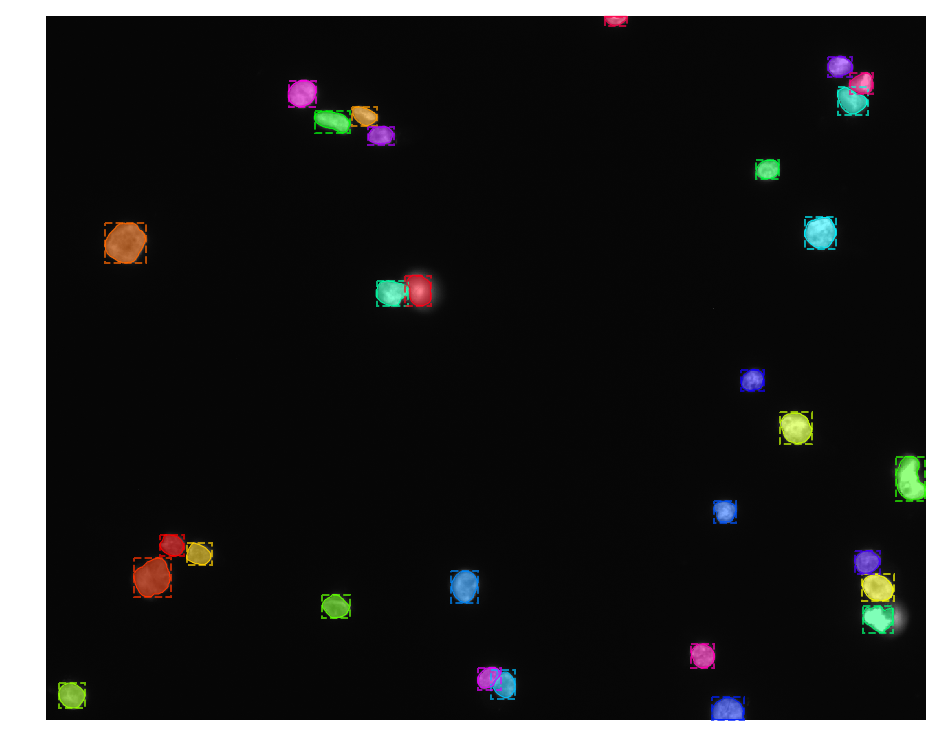

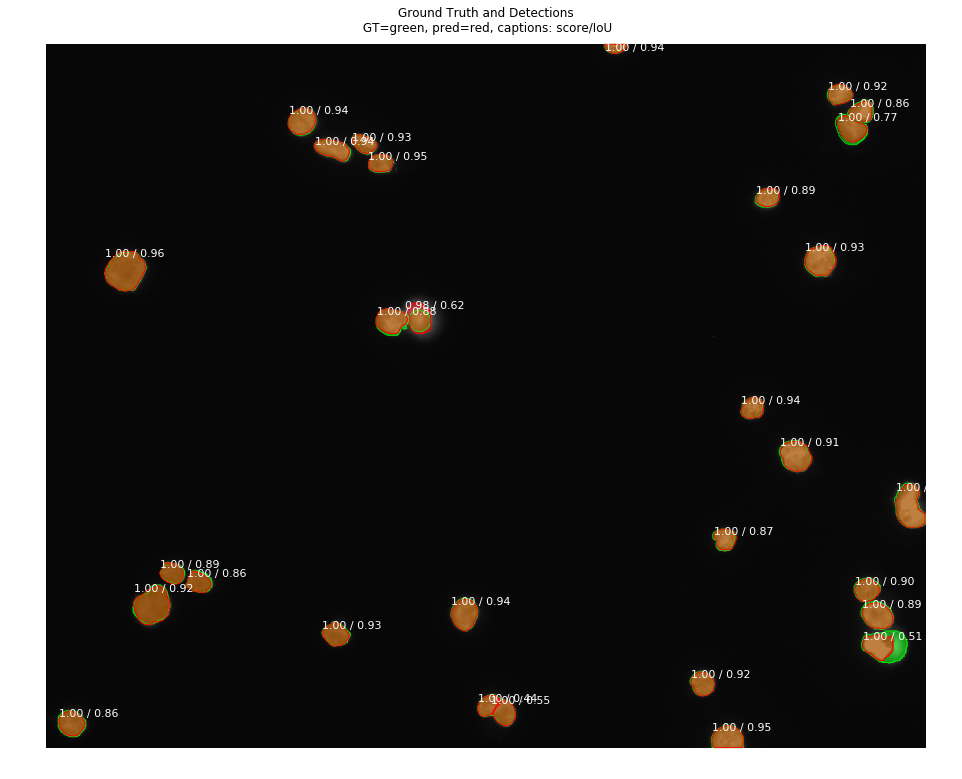

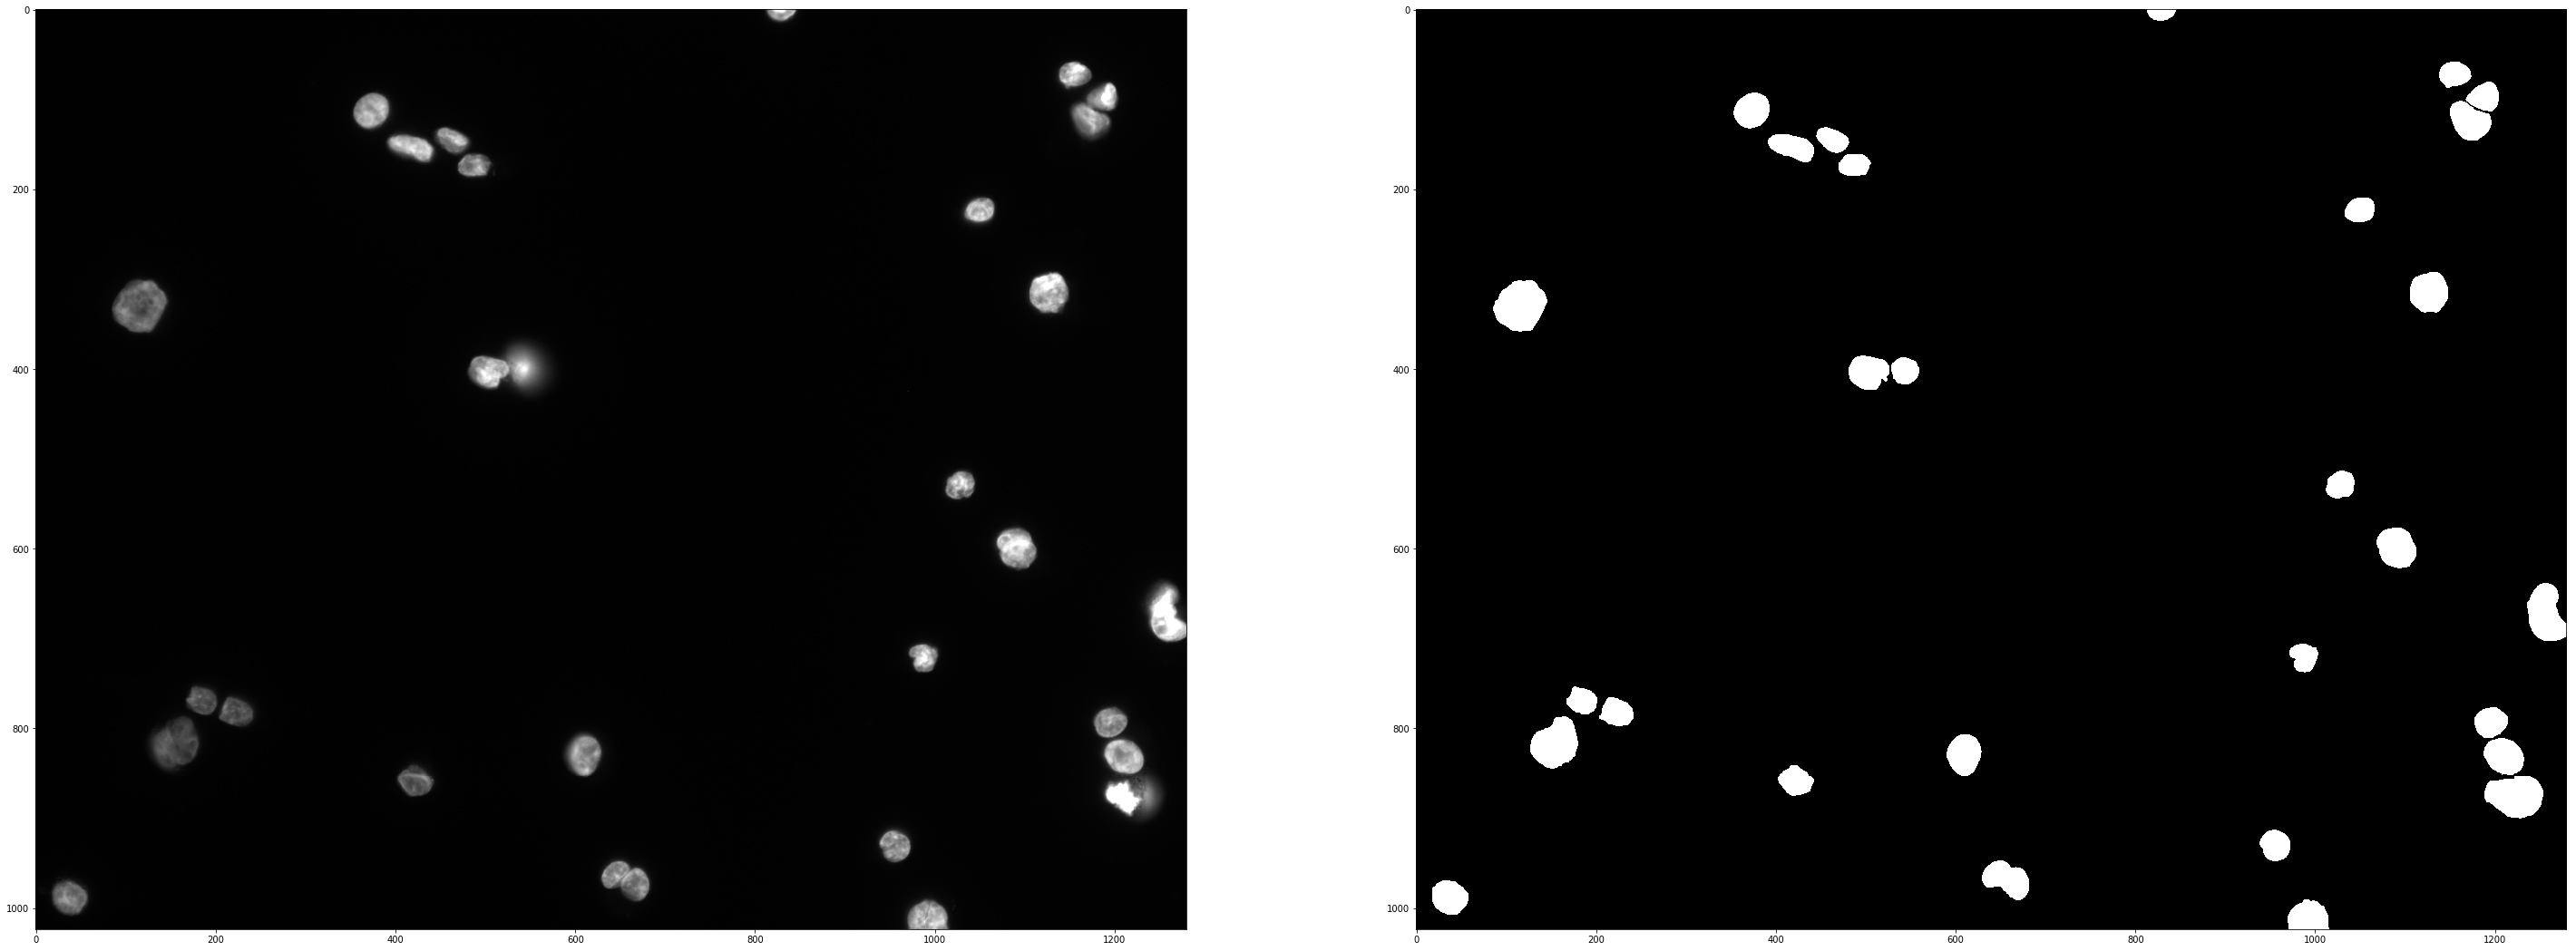

In [6]:
# Dataset
dataset = CoresDataset()
dataset.load_data(DATA_DIR,"")
dataset.prepare()

id = random.choice(dataset.image_ids)
filename = dataset.image_reference(id).rsplit('/', 2)[1]
print ("using " + filename)
image_path = os.path.join(IMAGE_DIR, filename)
gt_path = os.path.join(GT_DIR, filename)
image = skimage.io.imread(os.path.join(image_path, "0.png"))
color_image = skimage.color.gray2rgb(skimage.io.imread(os.path.join(image_path, "0.png")))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
image, core_image, image_meta, gt_class_id, gt_bbox, gt_mask, weight_image =\
modellib.load_image_gt(dataset, core_config, id, use_mini_mask=False)

visualize.display_instances(color_image, r['rois'], r['masks'], r['class_ids'], 
                            ['background',''], r['scores'], no_captions=True)
visualize.display_differences(color_image,
                    gt_bbox, gt_class_id, gt_mask,
                    r['rois'], r['class_ids'], r['scores'], r['masks'],
                    ['background','core'], title="", ax=None,
                    show_mask=True, show_box=False,
                    iou_threshold=0.5, score_threshold=0.5)

plt.figure(figsize=(50,50))
plt.subplot(121)
img=mpimg.imread(os.path.join(image_path, "0.png"), )
imgplot = plt.imshow(img, cmap='gray')
plt.subplot(122)
img=mpimg.imread(os.path.join(gt_path, "all", "0.png"), )
imgplot = plt.imshow(img, cmap='gray')
plt.show()

## Cell segmentation

In [7]:
model = modellib.MaskRCNN(mode="inference", 
                          config=cell_config,
                          model_dir="")
model.load_weights(cell_model_weights, by_name=True)

Processing 1 images
image                    shape: (1024, 1280, 1)       min:    6.00000  max:  255.00000  uint8
Processing 1 core original_images
core_image               shape: (1024, 1280, 1)       min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1280, 1)    min:   -0.41765  max:    0.55882  float32
molded_core_images       shape: (1, 1024, 1280, 1)    min:   -0.42157  max:    0.55882  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 327360, 4)        min:   -0.35390  max:    1.29134  float32
('Shapes molded images:', (1, 1024, 1280, 1), (1, 1024, 1280, 1))
1/1 [==============================] - 7s 7s/step


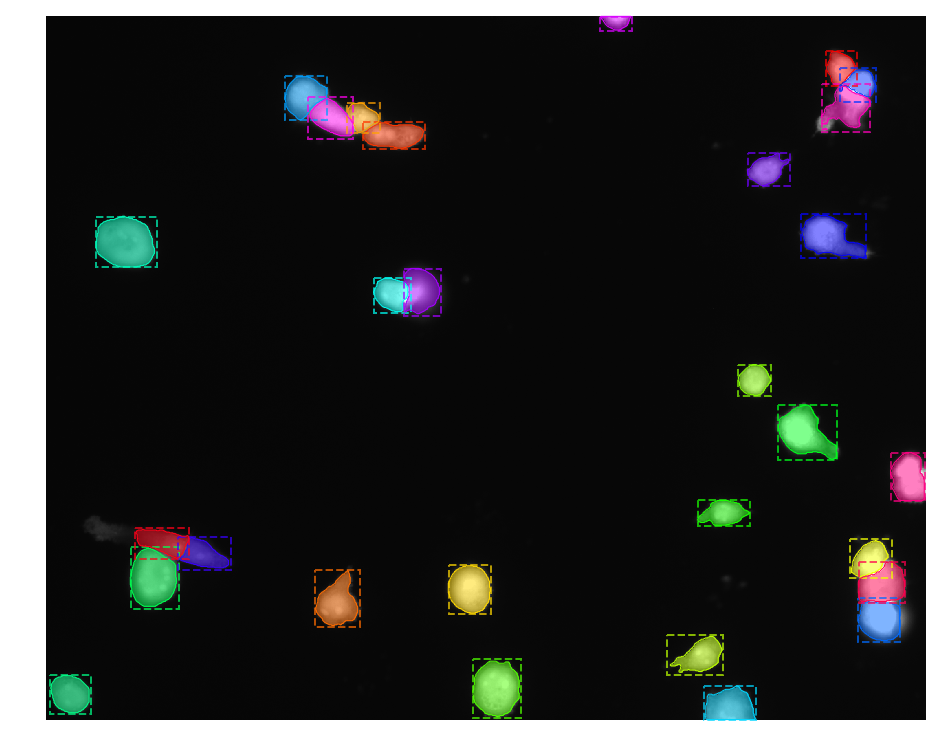

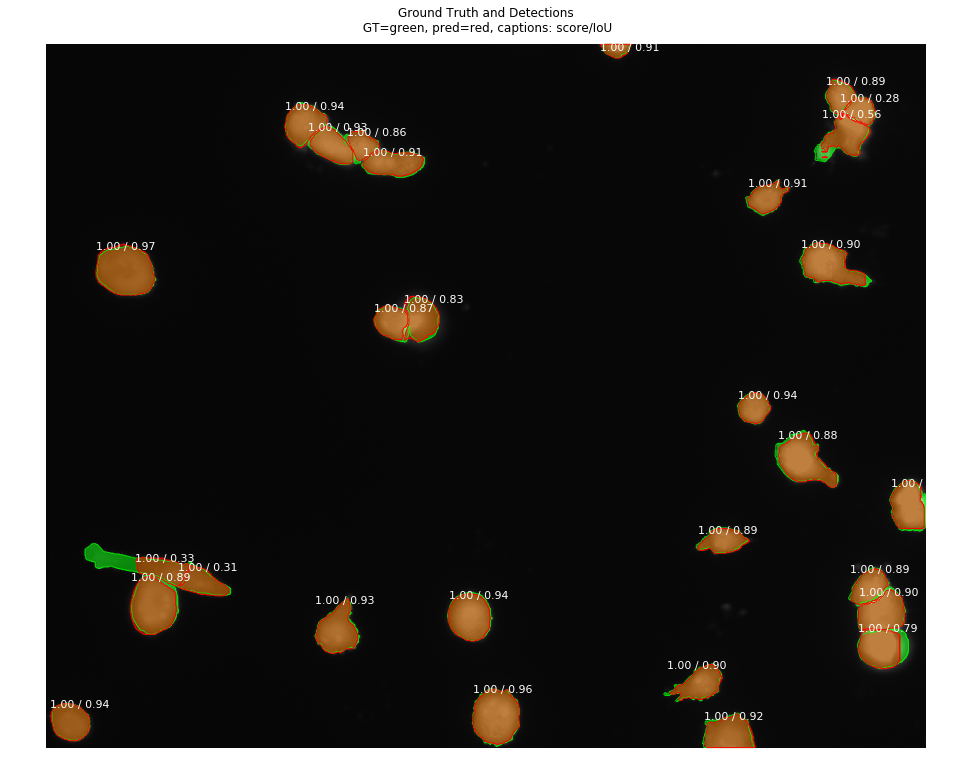

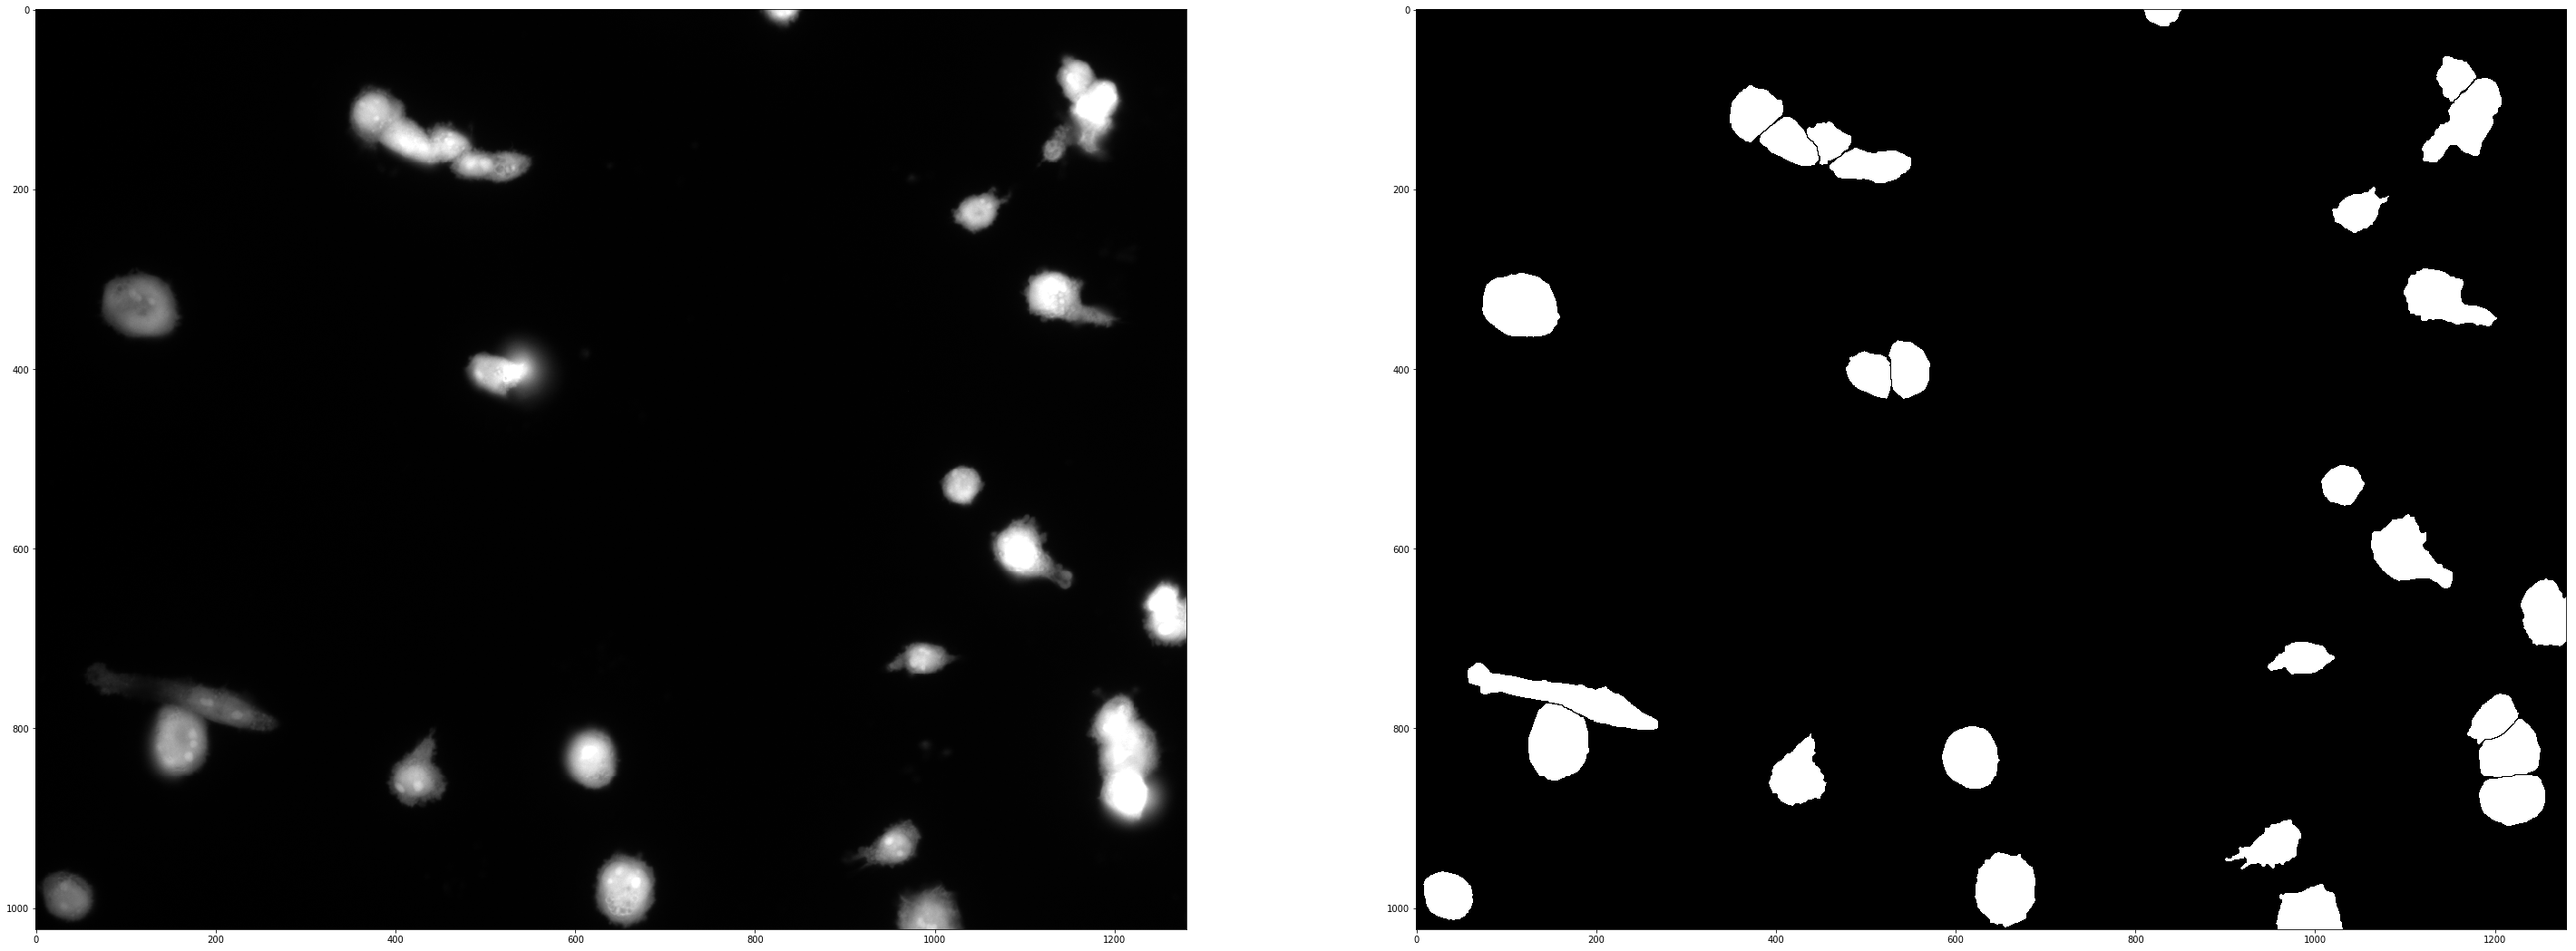

In [8]:
# Dataset
dataset = CellsWithCoresDataset()
dataset.load_data(DATA_DIR,"")
dataset.prepare()

image_path = os.path.join(IMAGE_DIR, filename)
gt_path = os.path.join(GT_DIR, filename)
image_core = skimage.io.imread(os.path.join(image_path, "0.png"))
image_cell = skimage.io.imread(os.path.join(image_path, "1.png"))
color_image = skimage.color.gray2rgb(skimage.io.imread(os.path.join(image_path, "1.png")))



# Run detection
results = model.detect([image_cell], [image_core], verbose=1)



# Visualize results
r = results[0]
image, core_image, image_meta, gt_class_id, gt_bbox, gt_mask, weight_image =\
modellib.load_image_gt(dataset, core_config, id, use_mini_mask=False)

visualize.display_instances(color_image, r['rois'], r['masks'], r['class_ids'], 
                            ['background','cell'], r['scores'], no_captions=True)

    
visualize.display_differences(color_image,
                    gt_bbox, gt_class_id, gt_mask,
                    r['rois'], r['class_ids'], r['scores'], r['masks'],
                    ['background','core'], title="", ax=None,
                    show_mask=True, show_box=False,
                    iou_threshold=0.5, score_threshold=0.5)

plt.figure(figsize=(50,50))
plt.subplot(121)
img=mpimg.imread(os.path.join(image_path, "1.png"), )
imgplot = plt.imshow(img, cmap='gray')
plt.subplot(122)
img=mpimg.imread(os.path.join(gt_path, "all", "1.png"), )
imgplot = plt.imshow(img, cmap='gray')
plt.show()